In [1]:
#from import_hosp_data import import_data
#from cleaning_data import add_cols_remove_rows
#from icd9_consolidation import consolidate_icd9_codes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importing & Merging Datasets

In [2]:
def import_files(file_name):
    """Reads in all CSV files and converts them to dataframes"""
    imported_file = pd.read_csv(f'full_data/{file_name}.csv')
    print(f"{file_name}.csv was imported")
    return imported_file

def creating_dataframe(admission, patients, diagnosis, services, icu):
    """Takes in individual dataframes and combines them on common columns"""
    adm = import_files(admission)
    pat = import_files(patients)
    diag = import_files(diagnosis)
    serv = import_files(services)
    icu = import_files(icu)
    print("All files loaded")
    return adm, pat, diag, serv, icu

def cleaning_column_names(data):
    data.columns = data.columns.str.strip().str.lower()
    return data

def merging_data(adm, pat, diag, serv, icu):
    raw_data = adm.merge(pat, how='outer', on='subject_id')
    raw_data = raw_data.merge(diag, how='outer', on=('subject_id', 'hadm_id'))
    raw_data = raw_data.merge(serv, how='outer', on=('subject_id', 'hadm_id'))
    raw_data = raw_data.merge(icu, how='outer', on=('subject_id', 'hadm_id'))
    print("All files were merged.")
    return raw_data

def selecting_columns(data):
    """Selects only relevant columns from the dataframe"""
    keeping_cols = ['subject_id',
                'hadm_id',
                'admittime',
                'dischtime',
                'admission_type',
                'admission_location',
                'insurance',
                'religion',
                'marital_status',
                'ethnicity',
                'gender',
                'dob',
                'deathtime',
                'icd9_code',
                'curr_service',
                "first_careunit"
               ]
    raw_data = data[keeping_cols]
    print("Appropriate columns were selected.")
    return raw_data

def import_data():
    adm, pat, diag, serv, icu = creating_dataframe('admissions_data', 'patient_data', 'diagnoses_icd_data', 'services_data', 'icustays')
    adm_c = cleaning_column_names(adm)
    pat_c = cleaning_column_names(pat)
    diag_c = cleaning_column_names(diag)
    serv_c = cleaning_column_names(serv)
    icu_c = cleaning_column_names(icu)
    merged_data = merging_data(adm_c, pat_c, diag_c, serv_c, icu_c)
    raw_data_selected_cols = selecting_columns(merged_data)
    print("Files imported.")
    print("Columns selected.")
    return raw_data_selected_cols


In [3]:
raw_data = import_data()

admissions_data.csv was imported
patient_data.csv was imported
diagnoses_icd_data.csv was imported
services_data.csv was imported
icustays.csv was imported
All files loaded
All files were merged.
Appropriate columns were selected.
Files imported.
Columns selected.


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853619 entries, 0 to 853618
Data columns (total 16 columns):
subject_id            853619 non-null int64
hadm_id               853619 non-null int64
admittime             853619 non-null object
dischtime             853619 non-null object
admission_type        853619 non-null object
admission_location    853619 non-null object
insurance             853619 non-null object
religion              849805 non-null object
marital_status        778707 non-null object
ethnicity             853619 non-null object
gender                853619 non-null object
dob                   853619 non-null object
deathtime             112472 non-null object
icd9_code             853572 non-null object
curr_service          853307 non-null object
first_careunit        2393 non-null object
dtypes: int64(2), object(14)
memory usage: 110.7+ MB


# Cleaning Data

9.5% of data was null and was removed

In [5]:
def add_los_columns(data):
    """Adds a new column to indicate length of stay in the hospital by
    subtracting the patient's admission time from their discharge time.
    Removes outliers in the data above 2 standard deviations.
    """
    data['los'] = (pd.to_datetime(data.dischtime) - pd.to_datetime(data.admittime)).dt.total_seconds()/86400
    data = data.drop(columns=['dischtime'])
    print("Length of stay column was added.")
    return data

def creating_age_column(data):
    """Creates an age column by subtracting the patient's date of birth from their admittime.
    Then removes any ages greater than 105 which are caused by a date adjustment error (see note).
    Note: for each user, dates have been modified by a random number of years. The modification
    number of years is consistent within a patient's listings accross all columns.
    """
    data['age'] = (pd.to_datetime(data.admittime).dt.date - pd.to_datetime(data.dob).dt.date)
    data['age'] = data['age'].apply(lambda x: round(x.days / 365,0))
    data = data[data.age < 105]
    data = data.drop(columns='dob')
    print("Age column was added.")
    print("DOB column was dropped")
    return data

def removing_dead_subjects(data):
    """Removes all subjects that died while in the hospital as their length of stay is
    not indicative of a standard patient's LOS"""
    data = data[data.deathtime.isna()]
    data = data.drop(columns = ['deathtime'])
    print("Patients who died in the hospital were removed.")
    return data

def isolating_firsts(data):
    grp_by_first_vis = data.groupby(['subject_id', 'hadm_id'])['admittime'].agg(['first']).reset_index()
    firsts_visits = grp_by_first_vis.merge(data, how='left', on=('subject_id', 'hadm_id'))
    print('Data isolated to first time visits only')
    firsts_visits = firsts_visits.drop(columns=['admittime', 'first'])
    return firsts_visits

def drop_nulls(data):
    data.first_careunit = data.first_careunit.fillna('not_admitted')
    null_dropped_data = data.dropna()
    print('Null values dropped.')
    return null_dropped_data

def add_cols_remove_rows(data):
    los_added = add_los_columns(data)
    add_age = creating_age_column(los_added)
    removed_daed = removing_dead_subjects(add_age)
    first_visits = isolating_firsts(removed_daed)
    null_dropped = drop_nulls(first_visits)
    return null_dropped

In [6]:
cleaned_data = add_cols_remove_rows(raw_data)

Length of stay column was added.
Age column was added.
DOB column was dropped
Patients who died in the hospital were removed.
Data isolated to first time visits only
Null values dropped.


# Consolidating ICD9_Code Values

In [7]:
cleaned_data.icd9_code.nunique()

6459

In [8]:
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: '.1' if 'V' in x else x)
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: '.8' if 'M' in x else x)
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: '.5' if 'E' in x else x)
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: x[:3] if ('E' not in x) & ('M' not in x) & ('V' not in x)else x)

In [9]:
cleaned_data.icd9_code = cleaned_data.icd9_code.astype(float)

In [10]:
cleaned_data.icd9_code.nunique()

838

In [11]:
def f(row):
    if 1 <= row['icd9_code'] <= 139:
        val = 'Parasitic_Disease'
    elif 140 <= row['icd9_code'] <= 239:
        val = 'Neoplasm'
    elif 240 <= row['icd9_code'] <= 279:
        val = 'Endocrine'
    elif 280 <= row['icd9_code'] <= 289:
        val = "Blood"
    elif 290 <= row['icd9_code'] <= 319:
        val = "Mental_Disorder"
    elif 320 <= row['icd9_code'] <= 389:
        val = "Nervous_System"
    elif 390 <= row['icd9_code'] <= 459:
        val = "Circulatory_System"
    elif 460 <= row['icd9_code'] <= 519:
        val = "Respiratory_System"
    elif 520 <= row['icd9_code'] <= 579:
        val = "Digestive_System"
    elif 580 <= row['icd9_code'] <= 629:
        val = "Genitourinary_System"
    elif 630 <= row['icd9_code'] <= 679:
        val = "Pregnancy"
    elif 680 <= row['icd9_code'] <= 709:
        val = "Skin"
    elif 710 <= row['icd9_code'] <= 739:
        val = "Musculoskeletal"
    elif 740 <= row['icd9_code'] <= 759:
        val = "Congenital_Anomalies"
    elif 760 <= row['icd9_code'] <= 779:
        val = "Perinatal"
    elif 780 <= row['icd9_code'] <= 799:
        val = "Ill-Defined"
    elif 800 <= row['icd9_code'] <= 999:
        val = "Injury/Poison"
    elif row['icd9_code'] < .4:
        val = "Supplemental_factors"
    elif .4 <= row['icd9_code'] < .7:
        val = "External_Cause_Inj_Poison"
    elif .7 <= row['icd9_code'] < .9:
        val = "Morphology_of_Neoplasms"     
    else:
        val = row['icd9_code']
    return val


cleaned_data['diagnoses'] = cleaned_data.apply(f, axis=1)
cleaned_data = cleaned_data.drop(columns=['icd9_code'])

In [12]:
cleaned_data['diagnoses'].nunique()

19

In [13]:
cleaned_data.diagnoses.unique()

array(['Parasitic_Disease', 'Ill-Defined', 'Genitourinary_System',
       'Circulatory_System', 'Skin', 'Endocrine', 'Digestive_System',
       'Supplemental_factors', 'External_Cause_Inj_Poison',
       'Injury/Poison', 'Blood', 'Neoplasm', 'Respiratory_System',
       'Mental_Disorder', 'Musculoskeletal', 'Congenital_Anomalies',
       'Nervous_System', 'Perinatal', 'Pregnancy'], dtype=object)

# Visualizing The Data

## Length Of Stay

In [14]:
#When looking at LOS, given that there is only one subj_id per patient, max, min, and mean are all equivalent
grp_by_hadm = cleaned_data.groupby('hadm_id').agg(['mean'])
grp_by_hadm.los.describe((.01, .75, .99))

,mean
count,41453.000000
mean,9.969328
std,10.539409
min,-0.450694
1%,0.644806
50%,6.961806
75%,11.884028
99%,51.745167
max,294.660417


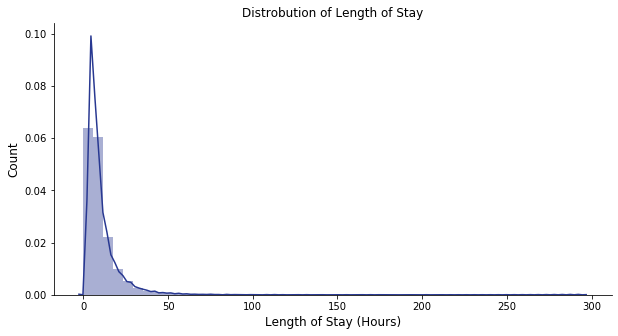

In [15]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
los_distro = sns.distplot(grp_by_hadm.los, color=bidmc_deep_blue)
    
los_distro.set_title('Distrobution of Length of Stay', fontsize=12)
los_distro.set_ylabel('Count', fontsize=12)
los_distro.set_xlabel('Length of Stay (Hours)', fontsize=12);
sns.despine()

In [16]:
eda_data = cleaned_data[cleaned_data.los < cleaned_data.los.quantile(q=.99)]

In [17]:
eda_data = eda_data[eda_data.los > eda_data.los.quantile(q=.01)]

In [18]:
eda_data.los.describe((.01, .75, .99))

count    627430.000000
mean         12.989549
std          11.152217
min           0.984028
1%            1.604167
50%           9.256944
75%          16.489583
99%          56.011806
max          70.406250
Name: los, dtype: float64

In [19]:
grp_by_hadm_id = eda_data.groupby('hadm_id').agg(['mean'])

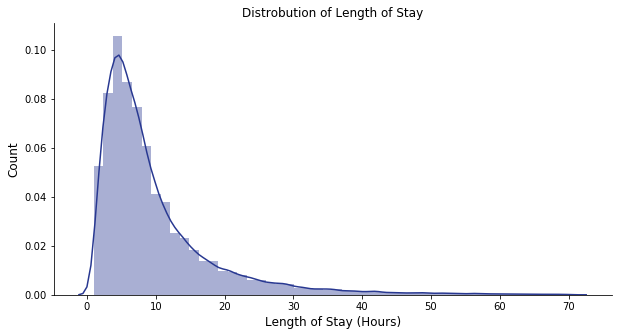

In [20]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
los_distro = sns.distplot(grp_by_hadm_id.los, color=bidmc_deep_blue)
    
los_distro.set_title('Distrobution of Length of Stay', fontsize=12)
los_distro.set_ylabel('Count', fontsize=12)
los_distro.set_xlabel('Length of Stay (Hours)', fontsize=12);
sns.despine()

In [150]:
mean_los = grp_by_hadm_id.los.mean()
mean_los

mean    9.839111
dtype: float64

holding to remove LOS anamolies

## Correlations

In [21]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 627430 entries, 3 to 707707
Data columns (total 14 columns):
subject_id            627430 non-null int64
hadm_id               627430 non-null int64
admission_type        627430 non-null object
admission_location    627430 non-null object
insurance             627430 non-null object
religion              627430 non-null object
marital_status        627430 non-null object
ethnicity             627430 non-null object
gender                627430 non-null object
curr_service          627430 non-null object
first_careunit        627430 non-null object
los                   627430 non-null float64
age                   627430 non-null float64
diagnoses             627430 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 91.8+ MB


### Admission Type

In [22]:
# in order to keep the categorical data, leveraging max 
grped_per_vis = eda_data.groupby('hadm_id').max()

In [23]:
grped_per_vis = grped_per_vis.reset_index()

In [24]:
grped_per_vis.admission_type.unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT', 'NEWBORN'], dtype=object)

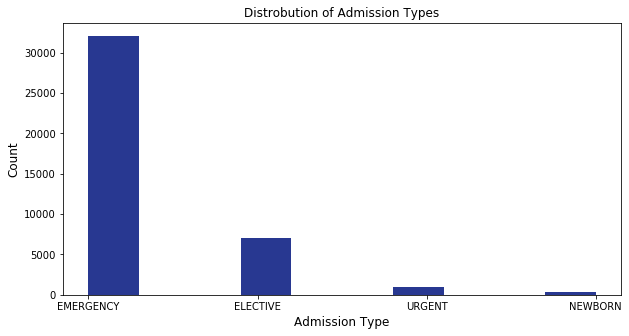

In [25]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
plt.hist(grped_per_vis.admission_type, color=bidmc_deep_blue)
    
plt.title('Distrobution of Admission Types', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Admission Type', fontsize=12);

In [26]:
grp_adm_type = grped_per_vis.groupby('admission_type')['los'].agg(['mean']).reset_index()
grp_adm_type = grp_adm_type.rename(columns={'mean':'mean_los'})
grp_adm_type

,admission_type,mean_los
0,ELECTIVE,8.532578
1,EMERGENCY,10.070029
2,NEWBORN,7.507905
3,URGENT,12.380599


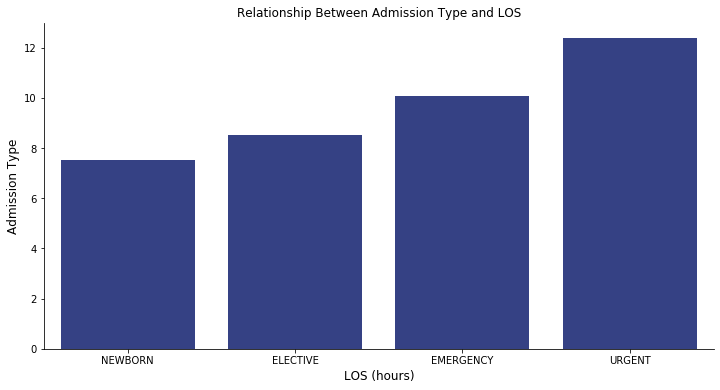

In [27]:
plt.figure(figsize=(12,6))
ethn_los = sns.barplot(y=grp_adm_type.mean_los, x = grp_adm_type.admission_type, color=bidmc_deep_blue, order=['NEWBORN', 'ELECTIVE','EMERGENCY','URGENT']);
    
ethn_los.set_title('Relationship Between Admission Type and LOS', fontsize=12)
ethn_los.set_ylabel('Admission Type', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Admission Location

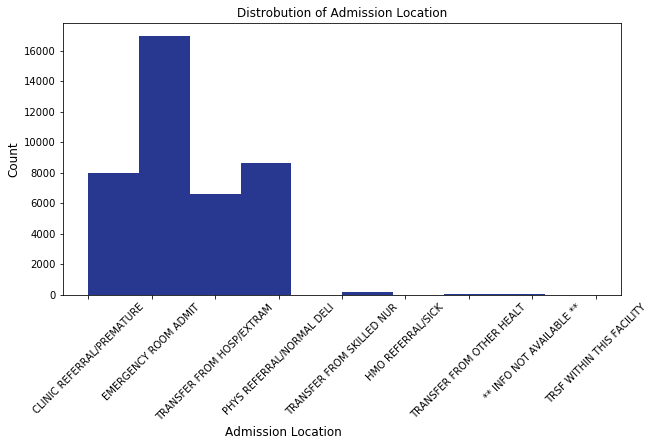

In [28]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
plt.hist(grped_per_vis.admission_location, color=bidmc_deep_blue)
    
plt.title('Distrobution of Admission Location', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Admission Location', fontsize=12, ha='right');
plt.xticks(rotation=45);

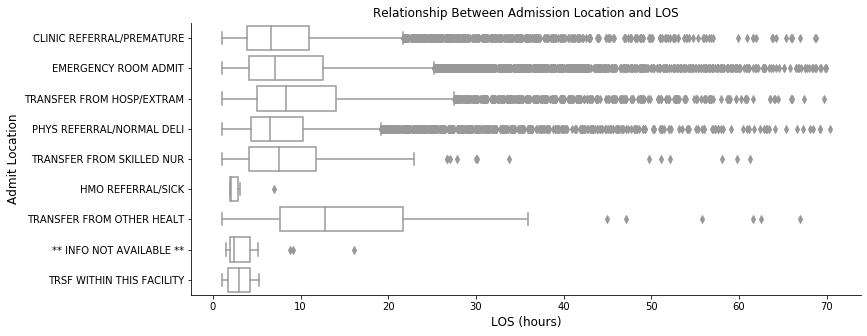

In [29]:
plt.figure(figsize=(12,5))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.admission_location, color='white');
    
ethn_los.set_title('Relationship Between Admission Location and LOS', fontsize=12)
ethn_los.set_ylabel('Admit Location', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Insurance

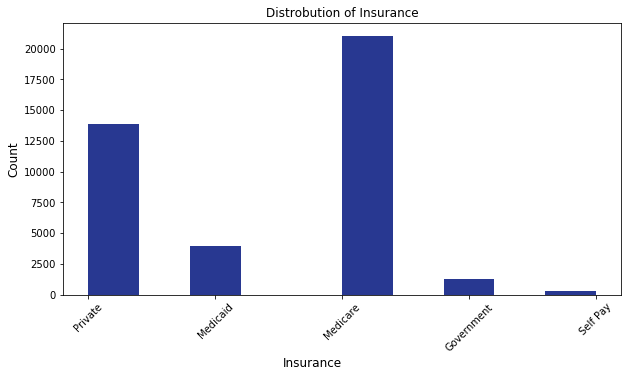

In [30]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
plt.hist(grped_per_vis.insurance, color=bidmc_deep_blue)
    
plt.title('Distrobution of Insurance', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Insurance', fontsize=12, ha='right');
plt.xticks(rotation=45);

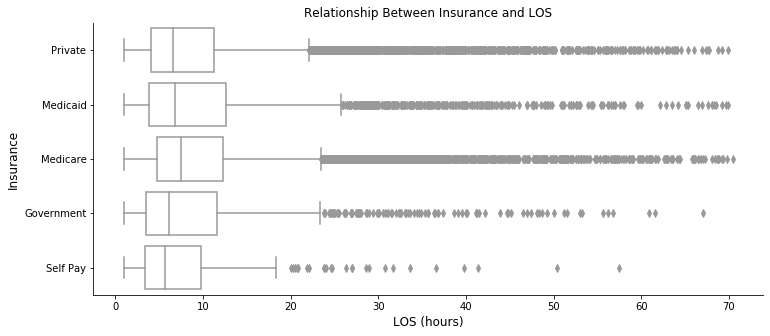

In [31]:
plt.figure(figsize=(12,5))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.insurance, color='white');
    
ethn_los.set_title('Relationship Between Insurance and LOS', fontsize=12)
ethn_los.set_ylabel('Insurance', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Religion

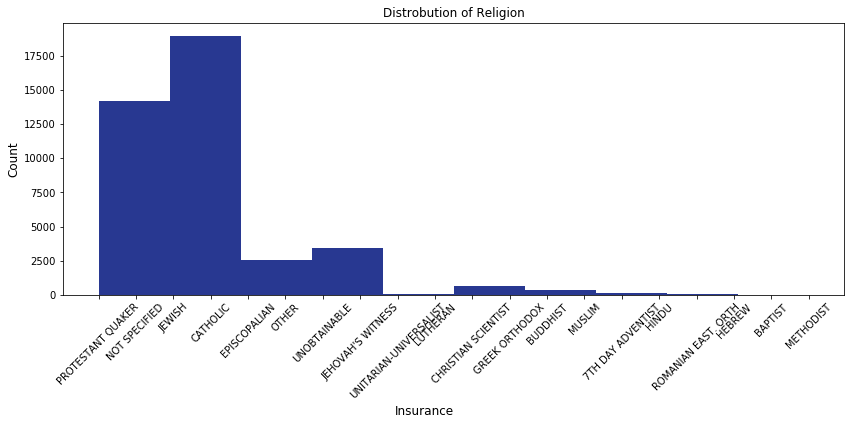

In [32]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.religion, color=bidmc_deep_blue)
    
plt.title('Distrobution of Religion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Insurance', fontsize=12, ha='right');
plt.xticks(rotation=45);

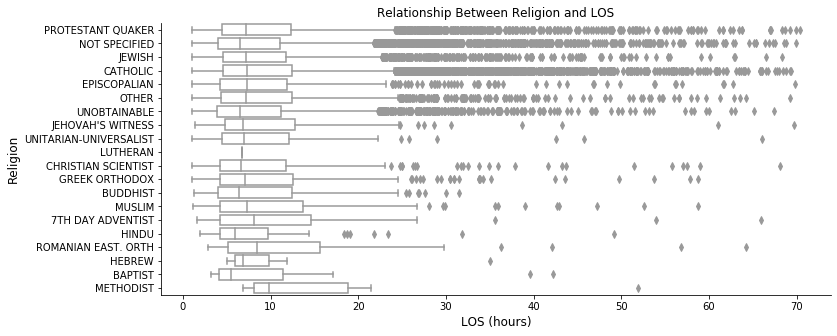

In [33]:
plt.figure(figsize=(12,5))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.religion, color='white');
    
ethn_los.set_title('Relationship Between Religion and LOS', fontsize=12)
ethn_los.set_ylabel('Religion', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Marital Status

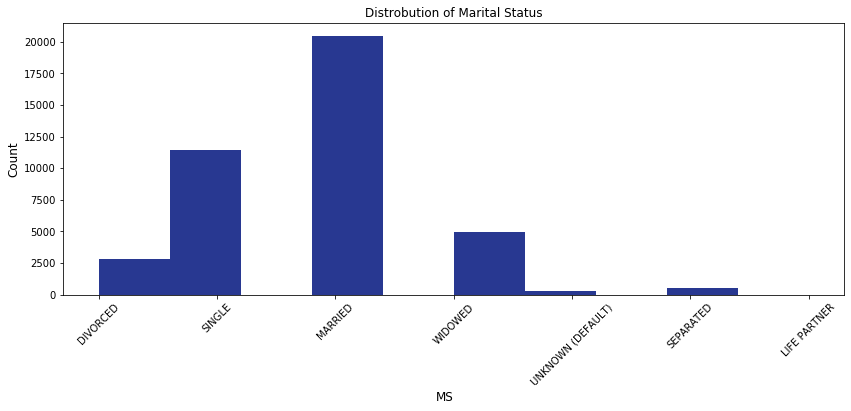

In [34]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.marital_status, color=bidmc_deep_blue)
    
plt.title('Distrobution of Marital Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('MS', fontsize=12, ha='right');
plt.xticks(rotation=45);

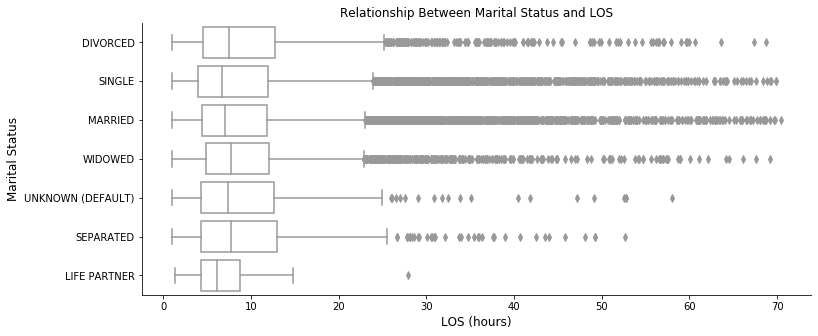

In [35]:
plt.figure(figsize=(12,5))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.marital_status, color='white');
    
ethn_los.set_title('Relationship Between Marital Status and LOS', fontsize=12)
ethn_los.set_ylabel('Marital Status', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Ethnicity

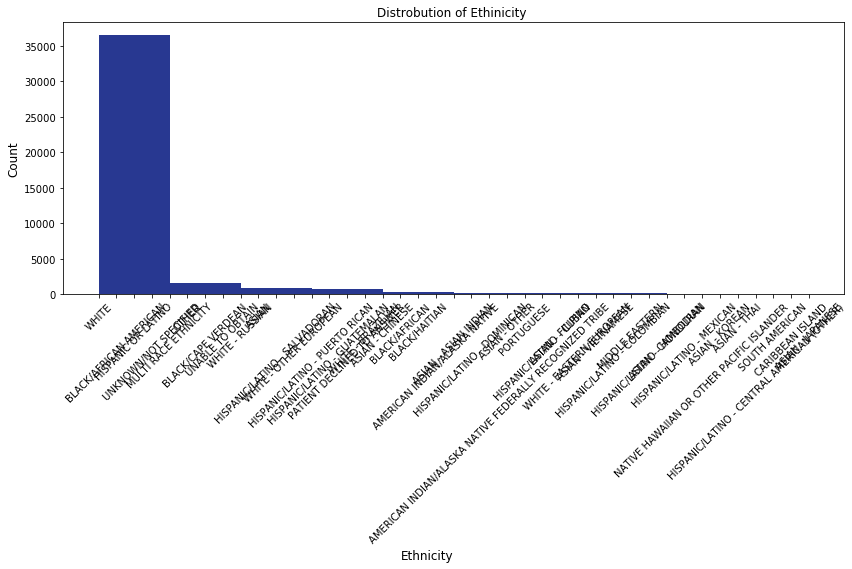

In [36]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.ethnicity, color=bidmc_deep_blue)
    
plt.title('Distrobution of Ethinicity ', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ethnicity', fontsize=12, ha='right');
plt.xticks(rotation=45);

### Gender 

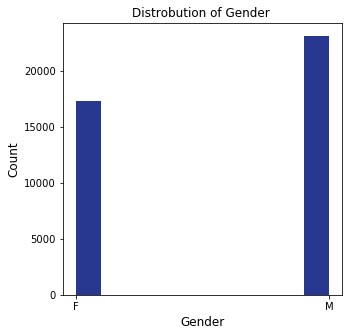

In [37]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(5,5))
plt.hist(grped_per_vis.gender, color=bidmc_deep_blue)
    
plt.title('Distrobution of Gender ', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12);

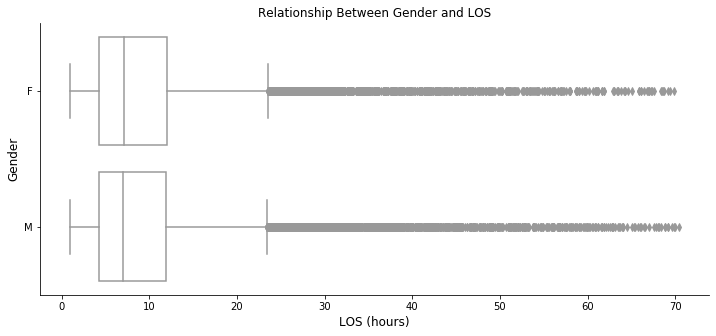

In [38]:
plt.figure(figsize=(12,5))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.gender, color='white');
    
ethn_los.set_title('Relationship Between Gender and LOS', fontsize=12)
ethn_los.set_ylabel('Gender', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### ICD9 Code

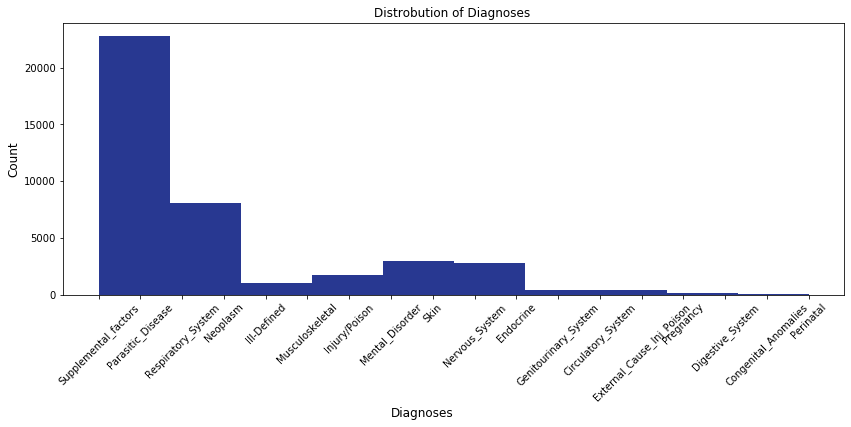

In [39]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.diagnoses, color=bidmc_deep_blue)
    
plt.title('Distrobution of Diagnoses ', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Diagnoses', fontsize=12, ha='right');
plt.xticks(rotation=45);

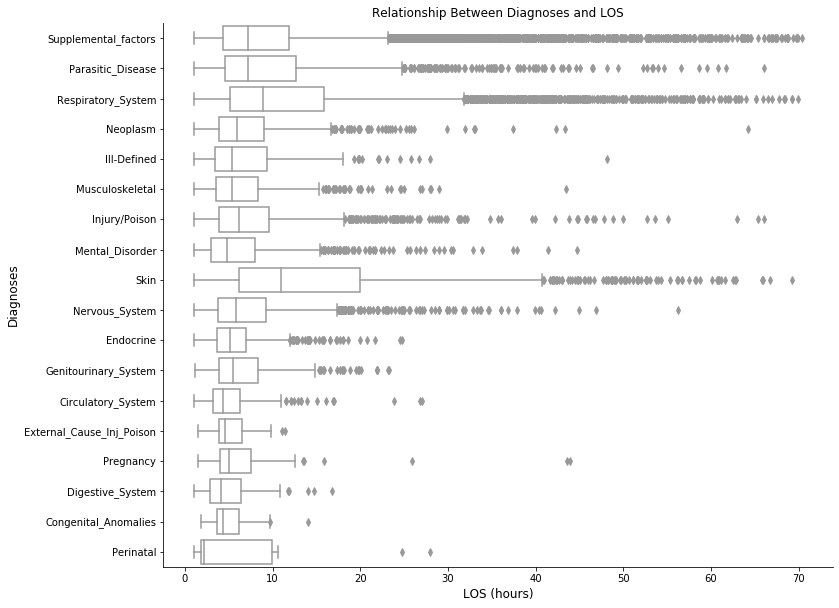

In [40]:
plt.figure(figsize=(12,10))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.diagnoses, color='white');
    
ethn_los.set_title('Relationship Between Diagnoses and LOS', fontsize=12)
ethn_los.set_ylabel('Diagnoses', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Current Service

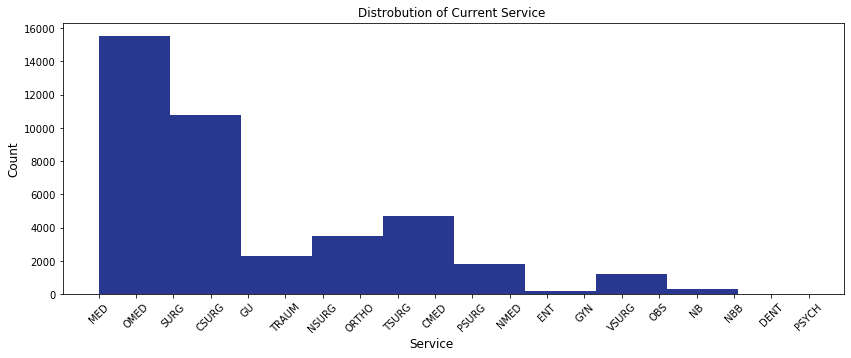

In [41]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.curr_service, color=bidmc_deep_blue)
    
plt.title('Distrobution of Current Service ', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Service', fontsize=12, ha='right');
plt.xticks(rotation=45);

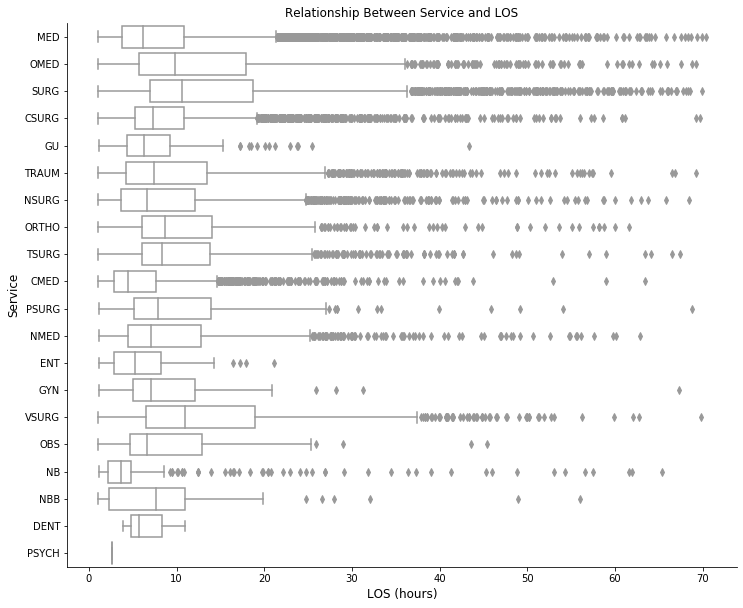

In [42]:
plt.figure(figsize=(12,10))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.curr_service, color='white');
    
ethn_los.set_title('Relationship Between Service and LOS', fontsize=12)
ethn_los.set_ylabel('Service', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Age

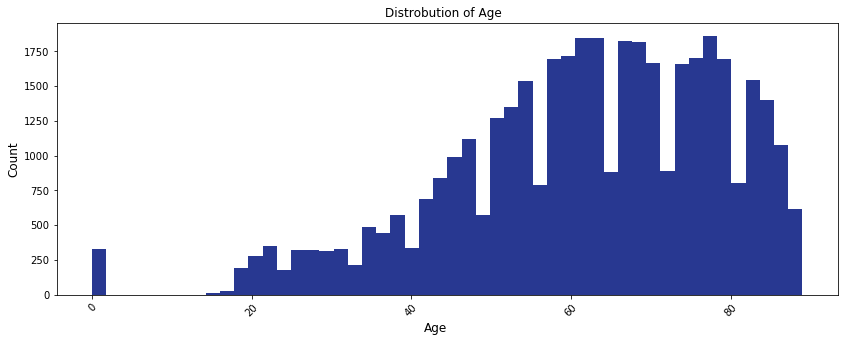

In [43]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.age, color=bidmc_deep_blue, bins=50)
    
plt.title('Distrobution of Age  ', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Age', fontsize=12, ha='right');
plt.xticks(rotation=45);

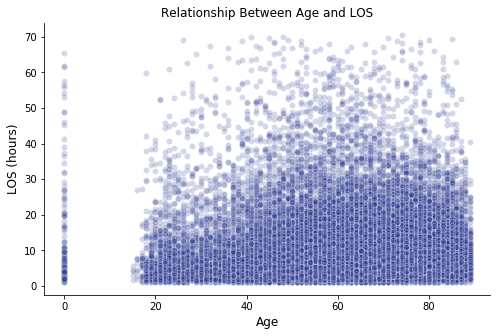

In [44]:
plt.figure(figsize=(8,5))
ethn_los = sns.scatterplot(y=grped_per_vis.los, x = grped_per_vis.age, color=bidmc_deep_blue, alpha=.2);
    
ethn_los.set_title('Relationship Between Age and LOS', fontsize=12)
ethn_los.set_ylabel('LOS (hours)', fontsize=12)
ethn_los.set_xlabel('Age', fontsize=12);
sns.despine()

### ICU/NICU

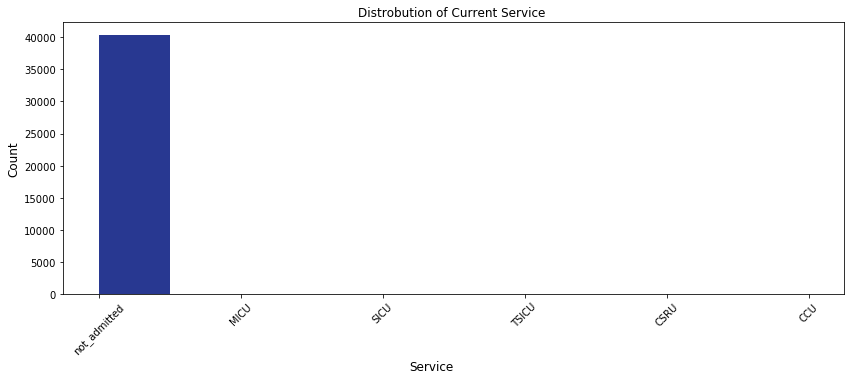

In [45]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.first_careunit, color=bidmc_deep_blue)
    
plt.title('Distrobution of Current Service ', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Service', fontsize=12, ha='right');
plt.xticks(rotation=45);

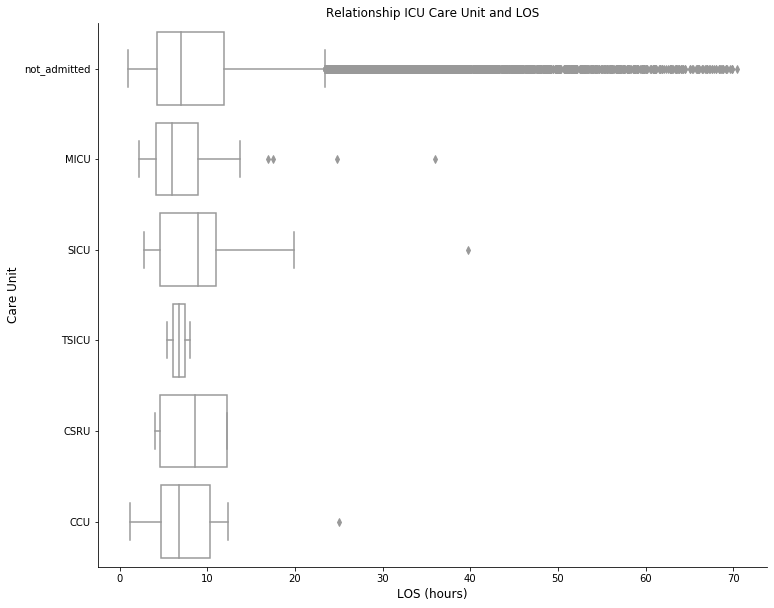

In [46]:
plt.figure(figsize=(12,10))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.first_careunit, color='white');
    
ethn_los.set_title('Relationship ICU Care Unit and LOS', fontsize=12)
ethn_los.set_ylabel('Care Unit', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

# Model Development

## Baseline Regression

In [47]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 627430 entries, 3 to 707707
Data columns (total 14 columns):
subject_id            627430 non-null int64
hadm_id               627430 non-null int64
admission_type        627430 non-null object
admission_location    627430 non-null object
insurance             627430 non-null object
religion              627430 non-null object
marital_status        627430 non-null object
ethnicity             627430 non-null object
gender                627430 non-null object
curr_service          627430 non-null object
first_careunit        627430 non-null object
los                   627430 non-null float64
age                   627430 non-null float64
diagnoses             627430 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 91.8+ MB


In [154]:
def dummy_cat_cols(data):
    """Creates dummy variables for each categorical column"""
    cat_cols = ['admission_type', 'admission_location', 'insurance', 'religion ', 'marital_status', 'ethnicity', 'gender', 'curr_service', 'diagnoses']
    dummied_data = pd.get_dummies(data, drop_first=True)
    grouped_dummy_data = dummied_data.groupby('hadm_id').max().reset_index()
    select_cols = grouped_dummy_data.drop(columns = ['subject_id', 'hadm_id'])
    print("Other dummy variables created.")
    return select_cols

In [155]:
dummied = dummy_cat_cols(eda_data)

Other dummy variables created.


In [163]:
dummied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40396 entries, 0 to 40395
Data columns (total 45 columns):
los                                    40396 non-null float64
admission_type_EMERGENCY               40396 non-null uint8
admission_type_NEWBORN                 40396 non-null uint8
admission_location_OTHER/UNKNOWN       40396 non-null uint8
admission_location_REFERRAL            40396 non-null uint8
admission_location_TRANSFER            40396 non-null uint8
insurance_Medicaid                     40396 non-null uint8
insurance_Medicare                     40396 non-null uint8
insurance_Private                      40396 non-null uint8
insurance_Self Pay                     40396 non-null uint8
religion_RELIGIOUS                     40396 non-null uint8
religion_UNOBTAINABLE                  40396 non-null uint8
marital_status_OTHER/UNKNOWN           40396 non-null uint8
marital_status_SINGLE                  40396 non-null uint8
ethnicity_BLACK_AFRICAN/OTHER          40396 non-

In [160]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

def splitting_test_and_train(data):
    x_obj_columns = [col for col in data.columns if (data[col].dtype == 'uint8') and (col != 'los')]
    x_fl_columns = [col for col in data.columns if (data[col].dtype == 'float64') and( col != 'los')]
    X_columns = x_fl_columns + x_obj_columns

    X, y = data[X_columns], np.log(data['los'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    X_train, y_train = np.array(X_train), np.array(y_train)
    print("Train and test data are separated")

    return X_train, X_test, y_train, y_test

def cross_val_testing(X_train, X_test, y_train, y_test):
    kf = KFold(n_splits=5, shuffle=True, random_state = 71)
    cv_lm_r2s, cv_lm_ridge_r2s, cv_lm_lasso_r2s, cv_lm_elastic_r2s = [], [], [], [] #collect the validation results for both models
    cv_lm_rmse, cv_lm_ridge_rmse, cv_lm_lasso_rmse, cv_lm_elastic_rmse = [], [], [], []
    print("Kfolds created. Running linear, ridge, lasso, and elastic net regressions.")

    for train_ind, val_ind in kf.split(X_train,y_train):

        X_tr, y_tr = X_train[train_ind], y_train[train_ind]
        X_val, y_val = X_train[val_ind], y_train[val_ind]

        #defining simple linear regression
        lm = LinearRegression()
        lm.fit(X_tr, y_tr)
        lm_predict = lm.predict(X_val)
        cv_lm_r2s.append(lm.score(X_val, y_val))
        cv_lm_rmse.append(np.sqrt(mean_squared_error(y_val, lm_predict)))
        
        #feature scaling for ridge and lasso fits
        #remove when not using numerical age column
        #scaler = StandardScaler()
        #X_tr[:, :1] = scaler.fit_transform(X_tr[:, :1])
        #X_val[:, :1] = scaler.transform(X_val[:, :1])

        #Defining ridge, lasso, elastic net regressions with scaled 'age' column
        lm_ridge = Ridge(alpha=1)
        lm_lasso = Lasso(alpha=1)
        lm_elastic = ElasticNet(alpha=1)

        #ridge regression
        lm_ridge.fit(X_tr, y_tr)
        lm_ridge_predict = lm_ridge.predict(X_val)
        cv_lm_ridge_r2s.append(lm_ridge.score(X_val, y_val))
        cv_lm_ridge_rmse.append(np.sqrt(mean_squared_error(y_val, lm_ridge_predict)))

        #lasso regression
        lm_lasso.fit(X_tr, y_tr)
        lm_lasso_predict = lm_lasso.predict(X_val)
        cv_lm_lasso_r2s.append(lm_lasso.score(X_val, y_val))
        cv_lm_lasso_rmse.append(np.sqrt(mean_squared_error(y_val, lm_lasso_predict)))

        #elastic net regression
        lm_elastic.fit(X_tr, y_tr)
        lm_elastic_predict = lm_elastic.predict(X_val)
        cv_lm_elastic_r2s.append(lm_elastic.score(X_val, y_val))
        cv_lm_elastic_rmse.append(np.sqrt(mean_squared_error(y_val, lm_elastic_predict)))

    print('Simple regression scores r^2: ', cv_lm_r2s)
    print('Ridge scores r^2: ', cv_lm_ridge_r2s, '\n')
    print('Lasso scores r^2: ', cv_lm_lasso_r2s, '\n')
    print('Elastic scores r^2: ', cv_lm_elastic_r2s, '\n')

    print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
    print(f'Ridge mean cv r^2: {np.mean(cv_lm_ridge_r2s):.3f} +- {np.std(cv_lm_ridge_r2s):.3f}')
    print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso_r2s):.3f} +- {np.std(cv_lm_lasso_r2s):.3f}')
    print(f'Elastic mean cv r^2: {np.mean(cv_lm_elastic_r2s):.3f} +- {np.std(cv_lm_elastic_r2s):.3f}\n')

    print('Simple regression scores rmse: ', cv_lm_rmse)
    print('Ridge scores rmse: ', cv_lm_ridge_rmse, '\n')
    print('Lasso scores rmse: ', cv_lm_lasso_rmse, '\n')
    print('Elastic scores rmse: ', cv_lm_elastic_rmse, '\n')

    print(f'Simple mean cv rmse: {np.mean(cv_lm_rmse):.3f} +- {np.std(cv_lm_rmse):.3f}')
    print(f'Ridge mean cv rmse: {np.mean(cv_lm_ridge_rmse):.3f} +- {np.std(cv_lm_ridge_rmse):.3f}')
    print(f'Lasso mean cv rmse: {np.mean(cv_lm_lasso_rmse):.3f} +- {np.std(cv_lm_lasso_rmse):.3f}')
    print(f'Elastic mean cv rmse: {np.mean(cv_lm_elastic_rmse):.3f} +- {np.std(cv_lm_elastic_rmse):.3f}')

    return


In [161]:
X_train, X_test, y_train, y_test = splitting_test_and_train(dummied)

Train and test data are separated


In [162]:
cross_val_testing(X_train, X_test, y_train, y_test)

Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.3178308800030686, 0.3030386347339371, 0.3023710739522485, 0.30962527022763164, 0.31270281321991167]
Ridge scores r^2:  [0.317836165200694, 0.30331393724959144, 0.30231596692220053, 0.30963622536595026, 0.31267352153319505] 

Lasso scores r^2:  [-0.00013618732144471402, -2.0033676150887914e-05, -0.00028581689720885706, -0.0002134735041734448, -0.0005957376433070039] 

Elastic scores r^2:  [-0.00013618732144471402, -2.0033676150887914e-05, -0.00028581689720885706, -0.0002134735041734448, -0.0005957376433070039] 

Simple mean cv r^2: 0.309 +- 0.006
Ridge mean cv r^2: 0.309 +- 0.006
Lasso mean cv r^2: -0.000 +- 0.000
Elastic mean cv r^2: -0.000 +- 0.000

Simple regression scores rmse:  [0.6362878574970486, 0.6473066386830354, 0.6407296692966283, 0.6446150635782161, 0.637993919954508]
Ridge scores rmse:  [0.6362853926291087, 0.6471787817053581, 0.6407549750219017, 0.6446099490549764,

# Feature Engineering

### adm_type

In [53]:
eda_data.admission_type.value_counts()

EMERGENCY    529446
ELECTIVE      81466
URGENT        15058
NEWBORN        1460
Name: admission_type, dtype: int64

In [54]:
def compressing_admission_type(data):
    data.admission_type = data.admission_type.apply(lambda x: 'EMERGENCY' if x == 'URGENT' else x)
    return data

### Age

In [55]:
eda_data.age.sort_values()

60360      0.0
265742     0.0
265743     0.0
265744     0.0
266008     0.0
          ... 
267213    89.0
267214    89.0
267215    89.0
267206    89.0
588009    89.0
Name: age, Length: 627430, dtype: float64

In [56]:
def r(row):
    if 0 <= row['age'] <= 3:
        val = 'Baby'
    elif 3 <= row['age'] <= 18:
        val = 'Child/Teen'
    elif 19 <= row['age'] <= 40:
        val = 'Young_Aduld'
    elif 41 <= row['age'] <= 60:
        val = "Adult"
    elif 61 <= row['age'] <= 100:
        val = "Senior"
    return val


def age_to_cat(data):
    data['age'] = data.apply(r, axis=1)
    return data

### First Care Unit

In [57]:
eda_data.first_careunit.value_counts()

not_admitted    626051
MICU               827
SICU               261
CCU                176
CSRU                70
TSICU               45
Name: first_careunit, dtype: int64

In [58]:
def compressing_careunit(data):
    data.first_careunit = data.first_careunit.apply(lambda x: 'ICU' if (x == 'MICU') | (x == 'SICU') | (x == 'CCU') | (x == 'CSRU') | (x == 'TSICU') else x)
    return data

### curr_serv

In [59]:
eda_data.curr_service.value_counts()

MED      257975
CMED      87054
CSURG     73656
SURG      55781
NSURG     27630
OMED      25568
NMED      22735
TRAUM     22335
VSURG     15255
TSURG     12813
ORTHO     12001
GU         4336
GYN        3351
PSURG      2216
ENT        1828
NB         1410
OBS        1251
NBB         195
DENT         36
PSYCH         4
Name: curr_service, dtype: int64

In [60]:
def compressing_curr_serv(data):
    data.curr_service = data.curr_service.apply(lambda x: 'SURGERGY' if (x == 'CSURG') | (x == 'NSURG') | (x == 'ORTHO') | (x == 'PSURG') | (x == 'SURG') | (x == 'TSURG') | (x == 'VSURG') else x)
    data.curr_service = data.curr_service.apply(lambda x: "MED" if (x == 'CMED') | (x == 'OMED') | (x == 'NMED') | (x == 'TRAUM') else x)
    data.curr_service = data.curr_service.apply(lambda x: "GYNOCOLOGY/NEWBORN" if (x == 'NB') | (x == 'NBB') | (x == 'OBS') | (x == 'GYN') else x)
    data.curr_service = data.curr_service.apply(lambda x: "OTHER" if (x == "GU") | (x == "ENT") | (x == "DENT") | (x == "PSYCH") else x)
    return data

### ethnicity

In [61]:
def compressing_ethnicity(data):
    data.ethnicity = data.ethnicity.apply(lambda x: 'WHITE' if ("WHITE" in x) else x)
    data.ethnicity = data.ethnicity.apply(lambda x: "ASIAN" if ("ASIAN" in x) else x)
    data.ethnicity = data.ethnicity.apply(lambda x: "HISPANIC/LATINO" if ("LATINA" in x) | ("HISPANIC" in x) else x)
    data.ethnicity = data.ethnicity.apply(lambda x: "OTHER/UNKNOWN" if (x=="AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE") | (x=="SOUTH AMERICAN") | (x=="CARIBBEAN ISLAND") | (x=="NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER") |(x=="AMERICAN INDIAN/ALASKA NATIVE") | (x=="MIDDLE EASTERN") | (x=="PORTUGUESE") | (x=="MULTI RACE ETHNICITY") | (x=="PATIENT DECLINED TO ANSWER") | (x=="OTHER") | ("UNKNOWN" in x) | ("OBTAIN" in x) else x)
    data.ethnicity = data.ethnicity.apply(lambda x: "BLACK_AFRICAN/OTHER" if ("BLACK" in x) else x)
    return data

### marital status

In [62]:
def compressing_marital_status(data):
    data.marital_status = data.marital_status.apply(lambda x: 'LIFE_PARTNER' if (x == 'MARRIED') | (x == 'LIFE PARTNER') else x)
    data.marital_status = data.marital_status.apply(lambda x: 'SINGLE' if (x == 'WIDOWED') | (x == 'DIVORCED') | (x == 'SEPARATED') else x)
    data.marital_status = data.marital_status.apply(lambda x: 'OTHER/UNKNOWN' if (x == 'UNKNOWN (DEFAULT)') else x)
    return data

### relgiion

In [63]:
eda_data.religion.value_counts()

CATHOLIC                  251330
NOT SPECIFIED             129929
PROTESTANT QUAKER          90527
JEWISH                     55990
UNOBTAINABLE               41836
OTHER                      26849
EPISCOPALIAN                9208
GREEK ORTHODOX              5993
CHRISTIAN SCIENTIST         4340
BUDDHIST                    2977
MUSLIM                      2488
JEHOVAH'S WITNESS           1628
7TH DAY ADVENTIST           1240
ROMANIAN EAST. ORTH         1064
UNITARIAN-UNIVERSALIST       994
HINDU                        714
BAPTIST                      169
HEBREW                        90
METHODIST                     58
LUTHERAN                       6
Name: religion, dtype: int64

In [64]:
def compressing_religion(data):
    data.religion = data.religion.apply(lambda x: 'RELIGIOUS' if (x == "LUTHERAN") | (x == "METHODIST") | (x == "HEBREW") | (x == "BAPTIST") | (x == "HINDU") | (x == "UNITARIAN-UNIVERSALIST") | (x == "ROMANIAN EAST. ORTH") | (x == "7TH DAY ADVENTIST") | (x == "JEHOVAH'S WITNESS") | (x == 'MUSLIM') | (x == 'BUDDHIST') | (x == 'CHRISTIAN SCIENTIST') | (x == 'GREEK ORTHODOX') | (x == 'EPISCOPALIAN') | (x == 'OTHER') | (x == 'JEWISH') | (x == 'CATHOLIC') | (x == 'PROTESTANT QUAKER') else x)
    return data

### Admission Location

In [66]:
def compressing_admit_location(data):
    data.admission_location = data.admission_location.apply(lambda x: 'ER_ADMIT' if (x == 'EMERGENCY ROOM ADMIT ') else x)
    data.admission_location = data.admission_location.apply(lambda x: 'REFERRAL' if (x == 'HMO REFERRAL/SICK') | (x == 'PHYS REFERRAL/NORMAL DELI') | (x == 'CLINIC REFERRAL/PREMATURE') else x)
    data.admission_location = data.admission_location.apply(lambda x: 'TRANSFER' if (x == 'TRANSFER FROM HOSP/EXTRAM') | (x == 'TRANSFER FROM SKILLED NUR') | (x == 'TRANSFER FROM OTHER HEALT') | (x == 'TRSF WITHIN THIS FACILITY')else x)
    data.admission_location = data.admission_location.apply(lambda x: 'OTHER/UNKNOWN' if (x == '** INFO NOT AVAILABLE **')  else x)
    return data

# Model After Engineering (No impact on diagnoses)

# Feature Engineering Model Dev

## No feature engineering

In [67]:
#alpha = 1
X_train, X_test, y_train, y_test = splitting_test_and_train(dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.2983170297581018, 0.2843492233553182, 0.29164515837297833, 0.2832497917706811, 0.28836364778571466]
Ridge scores r^2:  [0.2986331657126955, 0.28479654766049123, 0.29215743682525297, 0.2836263248044324, 0.28901154680786123] 

Lasso scores r^2:  [0.014368338329384223, 0.016234698074030218, 0.015573152385489508, 0.015098522292743666, 0.011849186685114366] 

Elastic scores r^2:  [0.05920284633043127, 0.054425156459291135, 0.05825246030060105, 0.06120643275205184, 0.059351847439559235] 

Simple mean cv r^2: 0.289 +- 0.005
Ridge mean cv r^2: 0.290 +- 0.005
Lasso mean cv r^2: 0.015 +- 0.002
Elastic mean cv r^2: 0.058 +- 0.002

Simple regression scores rmse:  [7.438611148961561, 7.705883278963431, 7.348643112820316, 7.391500462596009, 7.534005888551181]
Ridge scores rmse:  [7.436935265785342, 7.703474584797259, 7.345985382420933, 7.389558705427976, 7.53

## Consolidated admission type

In [68]:
fe_adm_type = compressing_admission_type(eda_data)

In [69]:
fe_adm_type_dummied = dummy_cat_cols(fe_adm_type)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_adm_type_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.29776744935959454, 0.28347788342117797, 0.2917947600462182, 0.28247281074130814, 0.2869628819510064]
Ridge scores r^2:  [0.2980903071671763, 0.28391926499521203, 0.2923181528783383, 0.282862590551079, 0.2875979622274799] 

Lasso scores r^2:  [0.014368338329384223, 0.016234698074030218, 0.015573152385489508, 0.015098522292743666, 0.011849186685114366] 

Elastic scores r^2:  [0.05920284633043127, 0.054425156459291135, 0.05825246030060105, 0.06120643275205184, 0.059351847439559235] 

Simple mean cv r^2: 0.288 +- 0.006
Ridge mean cv r^2: 0.289 +- 0.006
Lasso mean cv r^2: 0.015 +- 0.002
Elastic mean cv r^2: 0.058 +- 0.002

Simple regression scores rmse:  [7.441523657089084, 7.7105729973986685, 7.347867070014629, 7.395505693427747, 7.5414171104996495]
Ridge scores rmse:  [7.439812806300892, 7.708197753813951, 7.345151380

## Consolidate current service

In [70]:
fe_cs = compressing_curr_serv(eda_data)

In [71]:
fe_cs_dummied = dummy_cat_cols(fe_cs)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_cs_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.27387945006495074, 0.26062146962967536, 0.269034319291534, 0.26326811435882724, 0.2636391149672819]
Ridge scores r^2:  [0.27432384289900313, 0.26072896638574006, 0.2691407146532574, 0.2635906127343659, 0.26425676024301425] 

Lasso scores r^2:  [0.014368338329384223, 0.016234698074030218, 0.015573152385489508, 0.015098522292743666, 0.011849186685114366] 

Elastic scores r^2:  [0.06580081458475462, 0.06083709238524815, 0.06527121961429305, 0.06770802942478982, 0.0660222608818043] 

Simple mean cv r^2: 0.266 +- 0.005
Ridge mean cv r^2: 0.266 +- 0.005
Lasso mean cv r^2: 0.015 +- 0.002
Elastic mean cv r^2: 0.065 +- 0.002

Simple regression scores rmse:  [7.567035169477434, 7.832587781702132, 7.465006952657105, 7.493822942597828, 7.6637662217086]
Ridge scores rmse:  [7.564719265548705, 7.83201837892052, 7.464463650119486

## Consolidated ethnicity

In [72]:
fe_ethnicity = compressing_ethnicity(eda_data)

In [73]:
fe_ethnicity_dummied = dummy_cat_cols(fe_ethnicity)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_ethnicity_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.27460151927853693, 0.2602519870714384, 0.2691490356646128, 0.2634987151989796, 0.26529264154707954]
Ridge scores r^2:  [0.2748025649616862, 0.26033177246441497, 0.26920393530901443, 0.2637620799989213, 0.265328852006007] 

Lasso scores r^2:  [0.014368338329384223, 0.016234698074030218, 0.015573152385489508, 0.015098522292743666, 0.011849186685114366] 

Elastic scores r^2:  [0.06580081458475462, 0.06083709238524815, 0.06527121961429305, 0.06770802942478982, 0.0660222608818043] 

Simple mean cv r^2: 0.267 +- 0.005
Ridge mean cv r^2: 0.267 +- 0.005
Lasso mean cv r^2: 0.015 +- 0.002
Elastic mean cv r^2: 0.065 +- 0.002

Simple regression scores rmse:  [7.563271825932277, 7.834544589341484, 7.464421157628228, 7.492650048397118, 7.655156745427313]
Ridge scores rmse:  [7.562223665119353, 7.834122081228336, 7.46414079830521

## Consolidated Merital status

In [74]:
fe_ms = compressing_marital_status(eda_data)

In [75]:
fe_ms_dummied = dummy_cat_cols(fe_ms)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_ms_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.274496097624383, 0.26056810576129896, 0.26909308208801064, 0.26380576176441106, 0.26570789480917434]
Ridge scores r^2:  [0.27470013625149114, 0.2606472063398986, 0.2691482018117116, 0.26406197797383757, 0.2657080585778495] 

Lasso scores r^2:  [0.014368338329384223, 0.016234698074030218, 0.015573152385489508, 0.015098522292743666, 0.011849186685114366] 

Elastic scores r^2:  [0.06580081458475462, 0.06083709238524815, 0.06527121961429305, 0.06770802942478982, 0.0660222608818043] 

Simple mean cv r^2: 0.267 +- 0.005
Ridge mean cv r^2: 0.267 +- 0.005
Lasso mean cv r^2: 0.015 +- 0.002
Elastic mean cv r^2: 0.065 +- 0.002

Simple regression scores rmse:  [7.563821388470007, 7.832870430997971, 7.464706888295452, 7.491088046850463, 7.652993109752724]
Ridge scores rmse:  [7.562757700010759, 7.832451459921064, 7.464425415833

## Consolidated Religion

In [83]:
fe_religion = compressing_religion(eda_data)

In [84]:
fe_religion_dummied = dummy_cat_cols(fe_religion)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_religion_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.2705943881279379, 0.25551944330919385, 0.2663669698207565, 0.2632350001062934, 0.26138942314272606]
Ridge scores r^2:  [0.2706818797845184, 0.2560612421641213, 0.26635356247723807, 0.2650812365802244, 0.26244198677531183] 

Lasso scores r^2:  [0.014368338329384223, 0.016234698074030218, 0.015573152385489508, 0.015098522292743666, 0.011849186685114366] 

Elastic scores r^2:  [0.06580081458475462, 0.06083709238524815, 0.06527121961429305, 0.06770802942478982, 0.0660222608818043] 

Simple mean cv r^2: 0.263 +- 0.005
Ridge mean cv r^2: 0.264 +- 0.005
Lasso mean cv r^2: 0.015 +- 0.002
Elastic mean cv r^2: 0.065 +- 0.002

Simple regression scores rmse:  [7.584132969037101, 7.859565415887953, 7.478614739612042, 7.493991354988962, 7.675464265495751]
Ridge scores rmse:  [7.583678099863069, 7.856704979483069, 7.4786830761608

## Consolidated admissiong location

In [78]:
fe_adm_loc = compressing_admit_location(eda_data)

In [79]:
fe_adm_loc_dummied = dummy_cat_cols(fe_adm_loc)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_adm_loc_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.271917895820692, 0.2565256627393182, 0.2664842451636603, 0.2634791606911926, 0.26307691965744706]
Ridge scores r^2:  [0.272111985761598, 0.25664822418028577, 0.26653773120388685, 0.2636392883743941, 0.26308530986951495] 

Lasso scores r^2:  [0.014368338329384223, 0.016234698074030218, 0.015573152385489508, 0.015098522292743666, 0.011849186685114366] 

Elastic scores r^2:  [0.06580081458475462, 0.06083709238524815, 0.06527121961429305, 0.06770802942478982, 0.0660222608818043] 

Simple mean cv r^2: 0.264 +- 0.005
Ridge mean cv r^2: 0.264 +- 0.005
Lasso mean cv r^2: 0.015 +- 0.002
Elastic mean cv r^2: 0.065 +- 0.002

Simple regression scores rmse:  [7.577249134009942, 7.854252233844418, 7.478016966525653, 7.492749514694216, 7.666691221840513]
Ridge scores rmse:  [7.576239106533078, 7.853604822024833, 7.477744322887736

### Feature engineering all of it

In [80]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 627430 entries, 3 to 707707
Data columns (total 14 columns):
subject_id            627430 non-null int64
hadm_id               627430 non-null int64
admission_type        627430 non-null object
admission_location    627430 non-null object
insurance             627430 non-null object
religion              627430 non-null object
marital_status        627430 non-null object
ethnicity             627430 non-null object
gender                627430 non-null object
curr_service          627430 non-null object
first_careunit        627430 non-null object
los                   627430 non-null float64
age                   627430 non-null float64
diagnoses             627430 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 91.8+ MB


In [81]:
fe_adm_type = compressing_admission_type(eda_data)
fe_cs = compressing_curr_serv(fe_adm_type)
fe_ethnicity = compressing_ethnicity(fe_cs)
fe_ms = compressing_marital_status(fe_ethnicity)
fe_religion = compressing_religion(fe_ms)
fe_adm_loc = compressing_admit_location(fe_religion)
age_cat = age_to_cat(fe_adm_loc)
icu_admit = compressing_careunit(fe_adm_loc)

In [82]:
fe_all_dummied = dummy_cat_cols(icu_admit)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_all_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.2705943881279379, 0.25551944330919385, 0.2663669698207565, 0.2632350001062934, 0.26138942314272606]
Ridge scores r^2:  [0.2706818797845184, 0.2560612421641213, 0.26635356247723807, 0.2650812365802244, 0.26244198677531183] 

Lasso scores r^2:  [0.014368338329384223, 0.016234698074030218, 0.015573152385489508, 0.015098522292743666, 0.011849186685114366] 

Elastic scores r^2:  [0.06580081458475462, 0.06083709238524815, 0.06527121961429305, 0.06770802942478982, 0.0660222608818043] 

Simple mean cv r^2: 0.263 +- 0.005
Ridge mean cv r^2: 0.264 +- 0.005
Lasso mean cv r^2: 0.015 +- 0.002
Elastic mean cv r^2: 0.065 +- 0.002

Simple regression scores rmse:  [7.584132969037101, 7.859565415887953, 7.478614739612042, 7.493991354988962, 7.675464265495751]
Ridge scores rmse:  [7.583678099863069, 7.856704979483069, 7.4786830761608

# Stats Models

In [85]:
import statsmodels.api as sm

In [86]:
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_all_dummied)

Train and test data are separated


In [87]:
los_model = sm.OLS(y_train, X_train)

results = los_model.fit()

# summarize our model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     255.7
Date:                Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                        21:25:59   Log-Likelihood:            -1.1140e+05
No. Observations:               32316   AIC:                         2.229e+05
Df Residuals:                   32269   BIC:                         2.233e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.126e+12   5.07e+12      0.222      0.824   -8.82e+12    1.11e+13
x2          1.126e+12   5.07e+12      0.222      0.824   -8.82e+12    1.11e+13
x3          1.126e+12   5.07e+12      0.222      0.824   -8.82e+12    1.11e+13
x4         -2.064e+12   4.18e+12     -0.494      0.622   -1.03e+13    6.13e+12
x5         -2.064e+12   4.18e+12     -0.494      0.622   -1.03e+13    6.13e+12
x6         -2.064e+12   4.18e+12     -0.494      0.622   -1.03e+13    6.13e+12
x7         -2.064e+12   4.18e+12     -0.494      0.622   -1.03e+13    6.13e+12
x8         -2.309e+10   4.55e+11     -0.051      0.960   -9.16e+11     8.7e+11
x9         -2.309e+10   4.55e+11     -0.051      0.960   -9.16e+11     8.7e+11
x10        -2.309e+10   4.55e+11     -0.051      0.960   -9.16e+11     8.7e+11
x11        -2.309e+10   4.55e+11     -0.051      0.960   -9.16e+11     8.7e+11
x12        -2.309e+10   4.55e+11     -0.051      0.960   -9.16e+11     8.7e+11
x13          2.26e+11   1.16e+12      0.195      0.845   -2.05e+12     2.5e+12
x14          2.26e+11   1.16e+12      0.195      0.845   -2.05e+12     2.5e+12
x15          2.26e+11   1.16e+12      0.195      0.845   -2.05e+12     2.5e+12
x16         4.303e+11   1.55e+12      0.278      0.781    -2.6e+12    3.46e+12
x17         4.303e+11   1.55e+12      0.278      0.781    -2.6e+12    3.46e+12
x18         4.303e+11   1.55e+12      0.278      0.781    -2.6e+12    3.46e+12
x19        -9.017e+10   4.03e+11     -0.224      0.823    -8.8e+11       7e+11
x20        -9.017e+10   4.03e+11     -0.224      0.823    -8.8e+11       7e+11
x21        -9.017e+10   4.03e+11     -0.224      0.823    -8.8e+11       7e+11
x22        -9.017e+10   4.03e+11     -0.224      0.823    -8.8e+11       7e+11
x23        -9.017e+10   4.03e+11     -0.224      0.823    -8.8e+11       7e+11
x24         1.779e+11   1.46e+12      0.122      0.903   -2.69e+12    3.05e+12
x25         1.779e+11   1.46e+12      0.122      0.903   -2.69e+12    3.05e+12
x26            2.5441      0.609      4.178      0.000       1.351       3.738
x27            2.0769      0.146     14.195      0.000       1.790       2.364
x28            2.1206      0.380      5.581      0.000       1.376       2.865
x29            6.2430      0.128     48.815      0.000       5.992       6.494
x30         2.574e+11    1.6e+12      0.161      0.872   -2.87e+12    3.39e+12
x31         2.574e+11    1.6e+12      0.161      0.872   -2.87e+12    3.39e+12
x32        -4.089e+10   4.37e+11     -0.093      0.926   -8.98e+11    8.16e+11
x33        -4.089e+10   4.37e+11     -0.093      0.926   -8.98e+11    8.16e+11
x34        -4.089e+10   4.37e+11     -0.093      0.926   -8.98e+11    8.16e+11
x35        -4.089e+10   4.37e+11     -0.093      0.926   -8.98e+11    8.16e+11
x36        -4.089e+10   4.37e+11     -0.093      0.926   -8.98e+11    8.16e+11
x3

# removing last of each dummy

In [88]:
fe_all_dummied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40396 entries, 0 to 40395
Data columns (total 56 columns):
los                                        40396 non-null float64
admission_type_ELECTIVE                    40396 non-null uint8
admission_type_EMERGENCY                   40396 non-null uint8
admission_type_NEWBORN                     40396 non-null uint8
admission_location_EMERGENCY ROOM ADMIT    40396 non-null uint8
admission_location_OTHER/UNKNOWN           40396 non-null uint8
admission_location_REFERRAL                40396 non-null uint8
admission_location_TRANSFER                40396 non-null uint8
insurance_Government                       40396 non-null uint8
insurance_Medicaid                         40396 non-null uint8
insurance_Medicare                         40396 non-null uint8
insurance_Private                          40396 non-null uint8
insurance_Self Pay                         40396 non-null uint8
religion_NOT SPECIFIED                     40396 non-null

In [91]:
narrowed_cols = fe_all_dummied.drop(columns = ['admission_type_ELECTIVE', 
                                               'admission_location_OTHER/UNKNOWN', 
                                               'insurance_Self Pay',
                                               'religion_NOT SPECIFIED',
                                               'marital_status_OTHER/UNKNOWN',
                                               'ethnicity_OTHER/UNKNOWN', 
                                               'gender_F',
                                               'curr_service_OTHER',
                                               'first_careunit_not_admitted',
                                               'age_Child/Teen',
                                               'diagnoses_Blood'])

In [92]:
X_train, X_test, y_train, y_test = splitting_test_and_train(narrowed_cols)

los_model = sm.OLS(y_train, X_train)

results = los_model.fit()

# summarize our model
results.summary()

Train and test data are separated


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.669
Model:                            OLS   Adj. R-squared (uncentered):              0.668
Method:                 Least Squares   F-statistic:                              1482.
Date:                Wed, 22 Jan 2020   Prob (F-statistic):                        0.00
Time:                        21:30:56   Log-Likelihood:                     -1.1149e+05
No. Observations:               32316   AIC:                                  2.231e+05
Df Residuals:                   32272   BIC:                                  2.234e+05
Df Model:                          44                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8528      0.157      5.423      0.000       0.545       1.161
x2             5.7365      1.763      3.254      0.001       2.281       9.192
x3            -0.2598      0.988     -0.263      0.793      -2.197       1.677
x4            -1.4782      0.984     -1.502      0.133      -3.408       0.451
x5             0.0894      0.994      0.090      0.928      -1.858       2.037
x6             0.6286      0.522      1.204      0.228      -0.394       1.652
x7             0.5990      0.483      1.241      0.215      -0.347       1.545
x8            -0.2856      0.475     -0.602      0.547      -1.216       0.645
x9             0.1039      0.470      0.221      0.825      -0.817       1.024
x10            0.4399      0.108      4.085      0.000       0.229       0.651
x11           -0.0720      0.178     -0.405      0.685      -0.420       0.276
x12           -0.9706      0.541     -1.795      0.073      -2.030       0.089
x13           -0.9667      0.540     -1.789      0.074      -2.026       0.092
x14           -0.6527      0.308     -2.119      0.034      -1.256      -0.049
x15           -0.7965      0.196     -4.074      0.000      -1.180      -0.413
x16           -0.2652      0.258     -1.026      0.305      -0.772       0.241
x17           -0.3028      0.145     -2.087      0.037      -0.587      -0.018
x18            0.0816      0.090      0.911      0.362      -0.094       0.257
x19            2.5310      0.610      4.149      0.000       1.335       3.727
x20            2.0857      0.145     14.418      0.000       1.802       2.369
x21            6.0446      0.125     48.189      0.000       5.799       6.290
x22           -3.3594      0.943     -3.563      0.000      -5.207      -1.511
x23            0.2825      0.756      0.374      0.709      -1.199       1.764
x24           -2.2377      2.119     -1.056      0.291      -6.391       1.916
x25            0.0026      0.761      0.003      0.997      -1.490       1.495
x26            0.6363      0.758      0.840      0.401      -0.848       2.121
x27            1.0707      0.130      8.208      0.000       0.815       1.326
x28            0.6609      0.226      2.920      0.004       0.217       1.105
x29            1.3324      0.089     14.903      0.000       1.157       1.508
x30           -0.1333      0.100     -1.327      0.184      -0.330       0.064
x31           -0.4229      0.110     -3.836      0.000      -0.639      -0.207
x32            2.1910      0.097     22.617      0.000       2.001       2.381
x33            1.6140      0.094     17.246      0.000       1.431       1.797
x34            2.9687      0.105     28.156      0.000       2.762       3.175
x35           -0.3978      0.097     -4.084      0.000      -

In [135]:
X_train, X_test, y_train, y_test = splitting_test_and_train(narrowed_cols)
cross_val_testing(X_train, X_test, y_train, y_test)

Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.26606128111606986, 0.2543544807356769, 0.2612212729489184, 0.2590571344485222, 0.25903284058622555]
Ridge scores r^2:  [0.2660463592657033, 0.25454045165135586, 0.2611325246858346, 0.2590835602458904, 0.259029750210667] 

Lasso scores r^2:  [0.014368338329384223, 0.016234698074030218, 0.015573152385489508, 0.015098522292743666, 0.011849186685114366] 

Elastic scores r^2:  [0.06525118218427517, 0.06028696409767653, 0.06493655091894734, 0.06714124374273067, 0.0654511016918694] 

Simple mean cv r^2: 0.260 +- 0.004
Ridge mean cv r^2: 0.260 +- 0.004
Lasso mean cv r^2: 0.015 +- 0.002
Elastic mean cv r^2: 0.065 +- 0.002

Simple regression scores rmse:  [7.607663385749373, 7.865712332961056, 7.504796385741239, 7.515208859782766, 7.687699035160301]
Ridge scores rmse:  [7.607740721795808, 7.864731380948879, 7.505247141575393, 7.515074843270492, 7.68771506

# dropping additional columns

In [95]:
from sklearn.linear_model import lars_path

In [98]:
x_obj_columns = [col for col in narrowed_cols.columns if (narrowed_cols[col].dtype == 'uint8') and (col != 'los')]
x_fl_columns = [col for col in narrowed_cols.columns if (narrowed_cols[col].dtype == 'float64') and( col != 'los')]
X_columns = x_fl_columns + x_obj_columns

X, y = narrowed_cols[X_columns], narrowed_cols['los']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing


In [115]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32316 entries, 13264 to 17673
Data columns (total 44 columns):
admission_type_EMERGENCY                   32316 non-null uint8
admission_type_NEWBORN                     32316 non-null uint8
admission_location_EMERGENCY ROOM ADMIT    32316 non-null uint8
admission_location_REFERRAL                32316 non-null uint8
admission_location_TRANSFER                32316 non-null uint8
insurance_Government                       32316 non-null uint8
insurance_Medicaid                         32316 non-null uint8
insurance_Medicare                         32316 non-null uint8
insurance_Private                          32316 non-null uint8
religion_RELIGIOUS                         32316 non-null uint8
religion_UNOBTAINABLE                      32316 non-null uint8
marital_status_LIFE_PARTNER                32316 non-null uint8
marital_status_SINGLE                      32316 non-null uint8
ethnicity_ASIAN                            32316 non-nu

In [109]:
X_test.shape

(8080, 44)

In [108]:
y_train.shape

(32316,)

In [113]:
alphas, _, coefs = lars_path(X_train.values, y_train.values, method='lasso')

TypeError: No matching signature found

In [94]:
narrowed_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40396 entries, 0 to 40395
Data columns (total 45 columns):
los                                        40396 non-null float64
admission_type_EMERGENCY                   40396 non-null uint8
admission_type_NEWBORN                     40396 non-null uint8
admission_location_EMERGENCY ROOM ADMIT    40396 non-null uint8
admission_location_REFERRAL                40396 non-null uint8
admission_location_TRANSFER                40396 non-null uint8
insurance_Government                       40396 non-null uint8
insurance_Medicaid                         40396 non-null uint8
insurance_Medicare                         40396 non-null uint8
insurance_Private                          40396 non-null uint8
religion_RELIGIOUS                         40396 non-null uint8
religion_UNOBTAINABLE                      40396 non-null uint8
marital_status_LIFE_PARTNER                40396 non-null uint8
marital_status_SINGLE                      40396 non-null

In [116]:
#based on statsmodels p_values

In [129]:
narrowed_cols2 = narrowed_cols.drop(columns=['insurance_Government', 'insurance_Medicaid', 'insurance_Medicare', 'insurance_Private', 'admission_location_EMERGENCY ROOM ADMIT', 'admission_location_REFERRAL', 'admission_location_TRANSFER', 'gender_M'])

In [136]:
X_train, X_test, y_train, y_test = splitting_test_and_train(narrowed_cols2)
cross_val_testing(X_train, X_test, y_train, y_test)

Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.26277012148820067, 0.2502217756834788, 0.2572355161966511, 0.2536394634308573, 0.25586385083089747]
Ridge scores r^2:  [0.26277340383766845, 0.25038942497512806, 0.257160469041269, 0.25365382995597885, 0.25584505144442016] 

Lasso scores r^2:  [0.014368338329384223, 0.016234698074030218, 0.015573152385489508, 0.015098522292743666, 0.011849186685114366] 

Elastic scores r^2:  [0.06525118218427517, 0.06028696409767653, 0.06493655091894734, 0.06714124374273067, 0.0654511016918694] 

Simple mean cv r^2: 0.256 +- 0.004
Ridge mean cv r^2: 0.256 +- 0.004
Lasso mean cv r^2: 0.015 +- 0.002
Elastic mean cv r^2: 0.065 +- 0.002

Simple regression scores rmse:  [7.624701612207749, 7.887479882674378, 7.525013573631664, 7.542633899219249, 7.704120982102506]
Ridge scores rmse:  [7.624684638558238, 7.886598019012309, 7.525393718759212, 7.542561305643123, 7.70421

In [131]:
X_train, X_test, y_train, y_test = splitting_test_and_train(narrowed_cols2)

los_model = sm.OLS(y_train, X_train)

results = los_model.fit()

# summarize our model
results.summary()

Train and test data are separated


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.667
Model:                            OLS   Adj. R-squared (uncentered):              0.667
Method:                 Least Squares   F-statistic:                              1795.
Date:                Wed, 22 Jan 2020   Prob (F-statistic):                        0.00
Time:                        22:03:04   Log-Likelihood:                     -1.1159e+05
No. Observations:               32316   AIC:                                  2.232e+05
Df Residuals:                   32280   BIC:                                  2.235e+05
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7651      0.139     12.698      0.000       1.493       2.038
x2             6.0384      1.767      3.417      0.001       2.575       9.502
x3             0.4604      0.107      4.296      0.000       0.250       0.670
x4             0.0159      0.177      0.090      0.928      -0.330       0.362
x5            -1.2085      0.463     -2.610      0.009      -2.116      -0.301
x6            -1.2193      0.461     -2.642      0.008      -2.124      -0.315
x7            -0.7827      0.306     -2.561      0.010      -1.382      -0.184
x8            -0.9561      0.191     -5.012      0.000      -1.330      -0.582
x9            -0.3568      0.255     -1.399      0.162      -0.857       0.143
x10           -0.4420      0.142     -3.118      0.002      -0.720      -0.164
x11            2.3614      0.610      3.871      0.000       1.166       3.557
x12            2.1128      0.144     14.622      0.000       1.830       2.396
x13            6.0207      0.124     48.494      0.000       5.777       6.264
x14           -3.2821      0.945     -3.473      0.001      -5.134      -1.430
x15           -0.4537      0.487     -0.932      0.352      -1.408       0.501
x16           -2.7457      2.055     -1.336      0.181      -6.773       1.281
x17           -1.0088      0.490     -2.058      0.040      -1.970      -0.048
x18           -0.0594      0.490     -0.121      0.904      -1.020       0.901
x19            1.0630      0.130      8.166      0.000       0.808       1.318
x20            0.6096      0.227      2.687      0.007       0.165       1.054
x21            1.3243      0.090     14.776      0.000       1.149       1.500
x22           -0.1923      0.101     -1.913      0.056      -0.389       0.005
x23           -0.4761      0.110     -4.316      0.000      -0.692      -0.260
x24            2.1752      0.097     22.486      0.000       1.986       2.365
x25            1.5695      0.094     16.740      0.000       1.386       1.753
x26            2.9662      0.106     28.087      0.000       2.759       3.173
x27           -0.4159      0.097     -4.283      0.000      -0.606      -0.226
x28           -0.1994      0.110     -1.809      0.070      -0.416       0.017
x29            1.4800      0.118     12.565      0.000       1.249       1.711
x30            0.4889      0.097      5.037      0.000       0.299       0.679
x31            2.9799      0.109     27.408      0.000       2.767       3.193
x32            9.0159      0.979      9.211      0.000       7.097      10.934
x33            1.3752      0.820      1.677      0.094      -0.232       2.983
x34            3.6388      0.089     41.061      0.000       3.465       3.813
x35            2.9976      0.139     21.629      0.000       

In [132]:
narrowed_cols2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40396 entries, 0 to 40395
Data columns (total 37 columns):
los                                    40396 non-null float64
admission_type_EMERGENCY               40396 non-null uint8
admission_type_NEWBORN                 40396 non-null uint8
religion_RELIGIOUS                     40396 non-null uint8
religion_UNOBTAINABLE                  40396 non-null uint8
marital_status_LIFE_PARTNER            40396 non-null uint8
marital_status_SINGLE                  40396 non-null uint8
ethnicity_ASIAN                        40396 non-null uint8
ethnicity_BLACK_AFRICAN/OTHER          40396 non-null uint8
ethnicity_HISPANIC/LATINO              40396 non-null uint8
ethnicity_WHITE                        40396 non-null uint8
curr_service_GYNOCOLOGY/NEWBORN        40396 non-null uint8
curr_service_MED                       40396 non-null uint8
curr_service_SURGERGY                  40396 non-null uint8
first_careunit_ICU                     40396 non-

# Linear Regression Assumptions Testing

1. Confirmed, all factors are linear 

In [ ]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

# Ridge & Lasso Alpha testing

In [146]:
def splitting_test_and_train2(data):
    x_obj_columns = [col for col in data.columns if (data[col].dtype == 'uint8') and (col != 'los')]
    x_fl_columns = [col for col in data.columns if (data[col].dtype == 'float64') and( col != 'los')]
    X_columns = x_fl_columns + x_obj_columns

    X, y = data[X_columns], data['los']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    X_train, y_train = np.array(X_train), np.array(y_train)
    print("Train and test data are separated")

    return X_train, X_test, y_train, y_test

def cross_val_testing2(X_train, X_test, y_train, y_test):
    kf = KFold(n_splits=5, shuffle=True, random_state = 71)
    print("Kfolds created. Running linear, ridge, lasso, and elastic net regressions.")

    for train_ind, val_ind in kf.split(X_train,y_train):

        X_tr, y_tr = X_train[train_ind], y_train[train_ind]
        X_val, y_val = X_train[val_ind], y_train[val_ind]

        #Defining ridge, lasso, elastic net regressions with scaled 'age' column
        for a in range(-1,5):
            cv_lm_r2s, cv_lm_ridge_r2s, cv_lm_lasso_r2s, cv_lm_elastic_r2s = [], [], [], [] #collect the validation results for both models
            cv_lm_rmse, cv_lm_ridge_rmse, cv_lm_lasso_rmse, cv_lm_elastic_rmse = [], [], [], []
            
            lm_ridge = Ridge(alpha=10**a)
            lm_lasso = Lasso(alpha=10**a)
            lm_elastic = ElasticNet(alpha=10**a)

            #ridge regression
            lm_ridge.fit(X_tr, y_tr)
            lm_ridge_predict = lm_ridge.predict(X_val)
            cv_lm_ridge_r2s.append(lm_ridge.score(X_val, y_val))
            cv_lm_ridge_rmse.append(np.sqrt(mean_squared_error(y_val, lm_ridge_predict)))

            #lasso regression
            lm_lasso.fit(X_tr, y_tr)
            lm_lasso_predict = lm_lasso.predict(X_val)
            cv_lm_lasso_r2s.append(lm_lasso.score(X_val, y_val))
            cv_lm_lasso_rmse.append(np.sqrt(mean_squared_error(y_val, lm_lasso_predict)))

            #elastic net regression
            lm_elastic.fit(X_tr, y_tr)
            lm_elastic_predict = lm_elastic.predict(X_val)
            cv_lm_elastic_r2s.append(lm_elastic.score(X_val, y_val))
            cv_lm_elastic_rmse.append(np.sqrt(mean_squared_error(y_val, lm_elastic_predict)))

            print(f"alpha = {10**a}")
            print(f'Ridge mean cv r^2: {np.mean(cv_lm_ridge_r2s):.3f} +- {np.std(cv_lm_ridge_r2s):.3f}')
            print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso_r2s):.3f} +- {np.std(cv_lm_lasso_r2s):.3f}')
            print(f'Elastic mean cv r^2: {np.mean(cv_lm_elastic_r2s):.3f} +- {np.std(cv_lm_elastic_r2s):.3f}\n')

            print(f'Ridge mean cv rmse: {np.mean(cv_lm_ridge_rmse):.3f} +- {np.std(cv_lm_ridge_rmse):.3f}')
            print(f'Lasso mean cv rmse: {np.mean(cv_lm_lasso_rmse):.3f} +- {np.std(cv_lm_lasso_rmse):.3f}')
            print(f'Elastic mean cv rmse: {np.mean(cv_lm_elastic_rmse):.3f} +- {np.std(cv_lm_elastic_rmse):.3f}\n')

    return

In [147]:
X_train, X_test, y_train, y_test = splitting_test_and_train2(narrowed_cols2)
cross_val_testing2(X_train, X_test, y_train, y_test)

Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
alpha = 0.1
Ridge mean cv r^2: 0.263 +- 0.000
Lasso mean cv r^2: 0.239 +- 0.000
Elastic mean cv r^2: 0.232 +- 0.000

Ridge mean cv rmse: 7.625 +- 0.000
Lasso mean cv rmse: 7.749 +- 0.000
Elastic mean cv rmse: 7.780 +- 0.000

alpha = 1
Ridge mean cv r^2: 0.263 +- 0.000
Lasso mean cv r^2: 0.014 +- 0.000
Elastic mean cv r^2: 0.065 +- 0.000

Ridge mean cv rmse: 7.625 +- 0.000
Lasso mean cv rmse: 8.816 +- 0.000
Elastic mean cv rmse: 8.586 +- 0.000

alpha = 10
Ridge mean cv r^2: 0.263 +- 0.000
Lasso mean cv r^2: -0.000 +- 0.000
Elastic mean cv r^2: -0.000 +- 0.000

Ridge mean cv rmse: 7.624 +- 0.000
Lasso mean cv rmse: 8.880 +- 0.000
Elastic mean cv rmse: 8.880 +- 0.000

alpha = 100
Ridge mean cv r^2: 0.262 +- 0.000
Lasso mean cv r^2: -0.000 +- 0.000
Elastic mean cv r^2: -0.000 +- 0.000

Ridge mean cv rmse: 7.626 +- 0.000
Lasso mean cv rmse: 8.880 +- 0.000
Elastic mean cv rmse: 8.880 